In [21]:
#from PyQt5.QtWidgets import *
#from PyQt5.QtGui import *
#from PyQt5.QtCore import Qt
import os
from array import array
import numpy as np
from commpy.filters import rcosfilter
from commpy.filters import rrcosfilter
import matplotlib
import matplotlib.pyplot as plt
import ipympl
#%matplotlib inline
%matplotlib widget

In [22]:
#import matplotlib
#import matplotlib.pyplot as plt
#import numpy as np
#import cmath
#import math
#from commpy.filters import rcosfilter
#from ipywidgets import interact, widgets

In [23]:
from scipy.signal import butter, filtfilt
import os
from array import array
def read_signal(file_name, data_type):
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    iq_size_in_bytes = 4
    number_of_int_to_read = file_size // iq_size_in_bytes * 2
    arr = array(data_type)
    with open(file_path, 'rb') as fileobj:
        arr.fromfile(fileobj, number_of_int_to_read)
    i = np.array(arr[:: 2])
    i = i.reshape((len(i), 1))
    q = np.array(arr[1:: 2])
    q = q.reshape((len(q), 1))
    sig = np.empty((len(i), 1), complex)
    sig.real = i
    sig.imag = q
    sig_flatten = sig.flatten()
    return sig_flatten


def find_carr_freq(spectrum, min_sig_lvl):
    idx = list(np.where(spectrum >= min_sig_lvl))
    idx = idx[0]
    f_low = idx[0]
    f_high = idx[-1]
    carr_freq = round((f_low + f_high) / 2)
    return carr_freq


def mixing_signal(signal, freq):
    N = len(signal)
    k = freq
    n = np.arange(0, N, 1)
    mixer = np.exp(-1j * 2 * math.pi * k * n / N)
    mixed_signal = np.multiply(signal, mixer)
    return mixed_signal


def filter_signal(mixed_sig, normal_cutoff):
    order = 2
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    sig_filtered = filtfilt(b, a, mixed_sig)
    return sig_filtered

In [24]:
def resampling_lagrange_step_ver(s, step, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    #if (p > 1):
    #    if (q == 1):
    #        y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
    #    else:
    #        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    #else:
    #    y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    if (step > 1):
        y = np.zeros(int((len(s) -1) / step) + 1, dtype=np.csingle)
    else:
        y = np.zeros(int(len(s) / step), dtype=np.csingle) 
    
    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    print(f"len(y) = {len(y)}, len(t) = {len(t)}, len(s) = {len(s)}")

    for k in range(len(y)):
        #x = k * q / p - x0
        x = k * step - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        #print(f"x = {x}, n = {n}, d = {d}")
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1
        #print(f"a0 = {a0} a1 = {a1} a2 = {a2} a3 = {a3}")
        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    #print(t)
    return y

In [25]:
def resampling_lagrange(s, p, q, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    if (p > 1):
        if (q == 1):
            y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
        else:
            y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    else:
        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)

    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    for k in range(len(y)):
        x = k * q / p - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1

        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    return y


In [26]:
def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)

    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    plt.show()
    return yf

def add_freq(sig, f0_to_fsig):
    n = np.arange(0, len(sig), 1)
    mixer = np.exp(1j * np.pi * f0_to_fsig * n)
    #print(mixer[(821500 - 10 -1) : (821500 - 1)])
    return sig * mixer

In [27]:
def gen_rrc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    assert (n % 2 == 1), "RRC filter length should be odd!"
    n += 1 # because first sample will be not used
    s_psf = rrcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    return s_psf

In [28]:
def gen_rc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    assert (n % 2 == 1), "RC filter length should be odd!"
    n += 1 # because first sample will be not used
    s_psf = rcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    return s_psf

In [29]:
def add_phase(sig, phase):
# phase = [-1, 1] [semicircles]
    sig *= np.exp(1j * np.pi * phase)
    return sig

In [30]:
def save_cmplx_sig_to_int16(signal, filename):
    sig = np.round(signal)
    s_re = signal.real
    s_im = signal.imag
    arr_int16_re = s_re.astype(np.int16)
    arr_int16_im = s_im.astype(np.int16)
    arr_int = np.empty(len(two_sigs) * 2, dtype=int)
    print(len(arr_int))
    arr_int[ : : 2] = arr_int16_re
    arr_int[1 : : 2] = arr_int16_im
    saved_arr = arr_int.astype(np.int16)
    print(saved_arr[:30])
    with open(filename, 'wb') as f:
        saved_arr.tofile(f)

def save_cmplx_sig(signal, filename, data_type='int16'):
    sig = np.round(signal)
    s_re = signal.real
    s_im = signal.imag
    if data_type == 'int16':
        arr_to_type_re = s_re.astype(np.int16)
        arr_to_type_im = s_im.astype(np.int16)
        arr_int = np.empty(len(signal) * 2, dtype=int)
    if data_type == 'float32':
        arr_to_type_re = s_re.astype(np.float32)
        arr_to_type_im = s_im.astype(np.float32)
        arr_int = np.empty(len(signal) * 2, dtype=float)
    if data_type == 'float64':
        arr_to_type_re = s_re.astype(np.float64)
        arr_to_type_im = s_im.astype(np.float64)
        arr_int = np.empty(len(signal) * 2, dtype=np.float64)

    print(len(arr_int))
    arr_int[ : : 2] = arr_to_type_re
    arr_int[1 : : 2] = arr_to_type_im
    if data_type == 'int16':
        saved_arr = arr_int.astype(np.int16)
    if data_type == 'float32':
        saved_arr = arr_int.astype(np.float32)
    if data_type == 'float64':
        saved_arr = arr_int.astype(np.float64)
        
    print(saved_arr[:30])
    with open(filename, 'wb') as f:
        saved_arr.tofile(f)

In [31]:
def gen_qpsk_symbols(n_symb, fs):
    # create IQ of QPSK
    # complex array: [(1 + 1j, 1 -1j, ..., -1 -1j)]
    data = np.random.randint(0, 4, n_symb)
    #print(len(data))
    #x_tr = x.transpose()
    y = [-1 - 1j, -1 + 1j, 1 - 1j, 1 + 1j]
    iq = [y[val] for val in data]
    iq_ups = np.zeros(n_symb * fs, dtype=complex)
    iq_ups[:len(iq) * fs:fs] = iq
    return iq_ups

In [32]:
def plot_signal_power(signal, figure_counter, title="Signal Power"):
    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(0, len(signal))
    plt.plot(x_data, signal)
    plt.grid(1)
    plt.xlabel('time (samples)')
    plt.ylabel('Signal Power')
    plt.title(title)
    plt.show()

def upscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * np.floor(coeff)

In [33]:
# a = [7, 3, 5, 2, 1, 4, 1]
# b = [2, 3, 4, 3, 2, 1]
# conv = np.convolve(a, b, 'same')
# print(conv)

In [34]:
# N = 7
# Fs = 1
# T_symb = 8#1 / sig_board
# s_rc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
# plot_signal_power(s_rc, 0)
#
# N_symb = 2
# sps = 8 # f_sampling / f_symbol (SPS)
# s_qpsk = gen_qpsk_symbols(N_symb, sps)
# print(s_qpsk)
# plot_signal_power(s_qpsk, 1)
#
# qpsk_rc = np.convolve(s_qpsk, s_rc, 'same')
# print(qpsk_rc)
# plot_signal_power(qpsk_rc, 2)

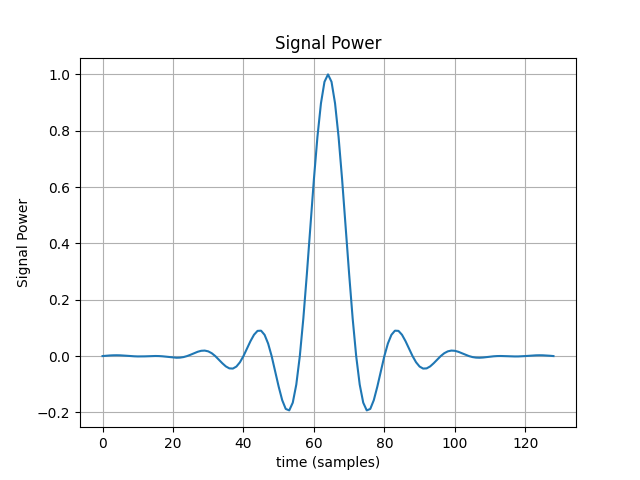

In [35]:
sig_board = 0.168
N = 129#100
Fs = 1
T_symb = 8#1 / sig_board
s_rc = gen_rc_filter_impulse_response(N, Fs, T_symb)
plot_signal_power(s_rc, 0)


f0 = 2.5 # f_carrier / f_symbol
phase_0 = 3 / 9 # semicircles
delay = 0.1

N_symb = N * 1000
sps = 8 # f_sampling / f_symbol (SPS)
s_qpsk = gen_qpsk_symbols(N_symb, sps)
qpsk_rc = np.convolve(s_qpsk, s_rc, 'same')


In [36]:

mixed_qpsk = add_freq(qpsk_rc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)

In [37]:
two_sigs = mixed_qpsk + qpsk_rc
two_sigs = upscale_to_i16(two_sigs)

(4.602644896153856-1.4783163189682789j)
4.602644896153856
4.62712219257646
7081.507389748612


In [38]:
save_cmplx_sig(two_sigs, 'qpsk_rc_float32.bid')

2064000
[-16971   5514  -5286  -3472    606   9196 -14623  11806 -16246  -5256
  -1370  -5650  -6116   6014 -17851  -4529  -5514 -16971   3982  -4979
  -9502   -761  -9934 -17387   8170 -16691   6286   -852  -6042  -6915]


129
1
8
(4.280663831471691-1.2657225600720734j)
4.280663831471691
4.288057608335678
7641.45517455346
2064000
[-18709.98389707   6669.63215688  -5993.29299694  -3620.07559104
   1090.21260212  10032.64540316 -15279.836255    13343.82487231
 -17450.33130335  -5194.97270576  -1456.37392733  -6015.99180454
  -6749.42151589   6333.65012549 -19530.57842611  -5682.00334305
  -5517.52801794 -19387.10904715   4700.11767293  -5596.03916187
 -10908.651235     -946.04373018 -11474.86740691 -19641.04995322
   8726.54513225 -18692.17339745   6756.69888077  -1010.50289865
  -6270.42820303  -7284.25382825]


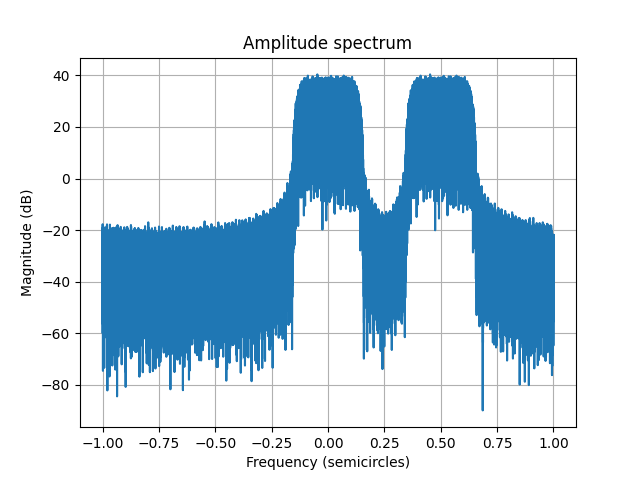

array([[-20.36285198],
       [-30.70123142],
       [-26.94062169],
       ...,
       [-24.29545975],
       [-28.37943918],
       [-25.89399978]])

In [39]:
print(N)
print(Fs)
print(T_symb)
s_rrc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
qpsk_rrc = np.convolve(s_qpsk, s_rrc, 'same')
mixed_qpsk = add_freq(qpsk_rrc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)
two_sigs = mixed_qpsk + qpsk_rrc
max(two_sigs)
two_sigs_upsc = upscale_to_i16(two_sigs)
save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float.bin', 'float64')
max(two_sigs_upsc)
plot_spectrum(two_sigs_upsc, 10)

129
1
8
(4.280663831471691-1.2657225600720734j)
4.280663831471691
4.288057608335678
7641.45517455346
sig len = 1032000
2064000
[-18709.98389707   6669.63215688  -5993.29299694  -3620.07559104
   1090.21260212  10032.64540316 -15279.836255    13343.82487231
 -17450.33130335  -5194.97270576  -1456.37392733  -6015.99180454
  -6749.42151589   6333.65012549 -19530.57842611  -5682.00334305
  -5517.52801794 -19387.10904715   4700.11767293  -5596.03916187
 -10908.651235     -946.04373018 -11474.86740691 -19641.04995322
   8726.54513225 -18692.17339745   6756.69888077  -1010.50289865
  -6270.42820303  -7284.25382825]
2064000
[-18709.984     6669.6323   -5993.293    -3620.0757    1090.2126
  10032.6455  -15279.836    13343.825   -17450.332    -5194.9727
  -1456.3739   -6015.9917   -6749.4214    6333.65    -19530.578
  -5682.0034   -5517.528   -19387.11      4700.1177   -5596.039
 -10908.651     -946.0437  -11474.867   -19641.05      8726.545
 -18692.174     6756.6987   -1010.50287  -6270.428    

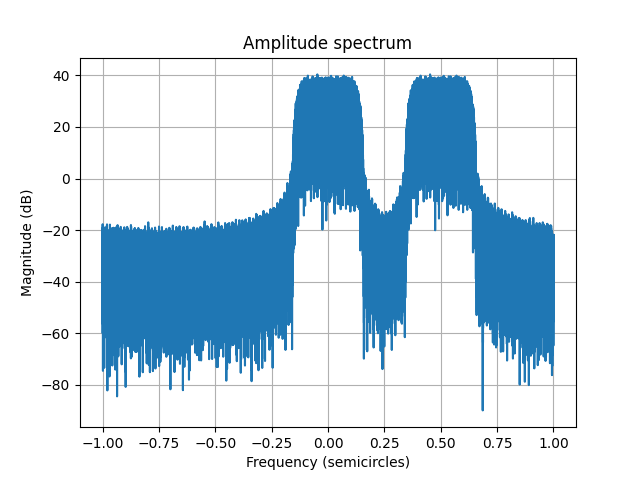

array([[-20.36285198],
       [-30.70123142],
       [-26.94062169],
       ...,
       [-24.29545975],
       [-28.37943918],
       [-25.89399978]])

In [50]:
print(N)
print(Fs)
print(T_symb)
s_rrc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
qpsk_rrc = np.convolve(s_qpsk, s_rrc, 'same')
mixed_qpsk = add_freq(qpsk_rrc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)
two_sigs = mixed_qpsk + qpsk_rrc
two_sigs_upsc = upscale_to_i16(two_sigs)
print(f"sig len = {len(two_sigs_upsc)}")
save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float64.bin', 'float64')
save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float32.bin', 'float32')
max(two_sigs_upsc)
plot_spectrum(two_sigs_upsc, 10)

(15.737641014435978+10.090527380608437j)
15.737641014435978
15.729414493955506
2082.0782460308483
2064000
[-12684   7264 -15627   7199 -18283   6195 -20384   4199 -21723   1325
 -22196  -2256 -21701  -6347 -20152 -10634 -17593 -14736 -14168 -18347
 -10024 -21224  -5357 -23150   -434 -24014   4498 -23817   9215 -22597]


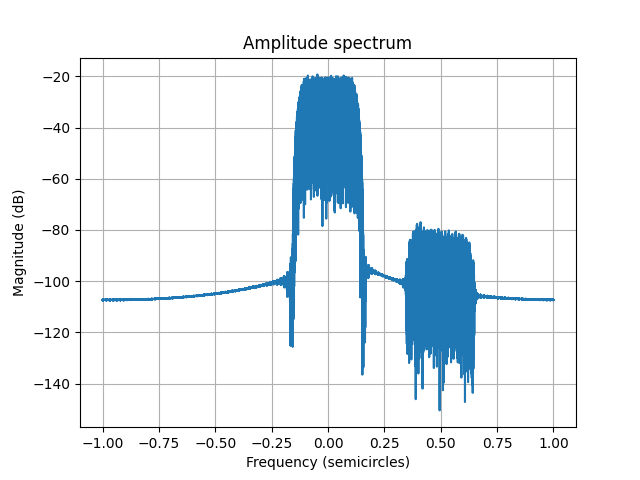

array([[-107.39420893],
       [-107.31679461],
       [-107.3443669 ],
       ...,
       [-107.38537787],
       [-107.30049768],
       [-107.25249241]])

In [45]:
qpsk_rrc_rrc = np.convolve(two_sigs, s_rrc, 'same')
two_sigs_upsc = upscale_to_i16(qpsk_rrc_rrc)
save_cmplx_sig_to_int16(two_sigs_upsc, 'qpsk_rrc_rrc_int16_.bin')

plot_spectrum(qpsk_rrc_rrc, 1)

(1.95332457732921+1.2245444407532553j)
1.95332457732921
1.95332457732921
16774.98987126987


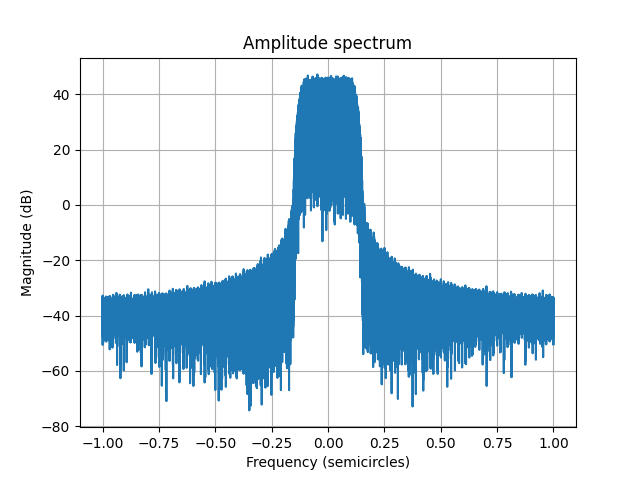

array([[-33.24627165],
       [-38.51599497],
       [-37.04413586],
       ...,
       [-35.14508289],
       [-37.42652655],
       [-43.4236885 ]])

In [42]:
qpsk_upsc = upscale_to_i16(qpsk_rc)
plot_spectrum(qpsk_upsc, 2)

In [43]:
save_cmplx_sig_to_int16(qpsk_upsc, 'qpsk_rc_int16_1_sig.bin')

2064000
[-16774  16774 -18918  15159 -20658  12302 -21863   8356 -22415   3578
 -22222  -1697 -21224  -7094 -19400 -12235 -16774 -16774 -13436 -20415
  -9484 -22991  -5074 -24417   -396 -24700   4340 -23927   8917 -22237]
